In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


#### Explaoratory Data Analysis - Step 1
Starting to see what the data looks like.

In [18]:
#loading all important files for image reading, csv reading, etc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.image as mpimg
import random
from PIL import Image
import collections
import cv2
import scipy as sp
import copy

In [19]:
#setting image height and image width
np.random.seed(42)
sns.set_style("dark")

In [20]:
#### Basic Statistics
print('The number of training examples are:', len(os.listdir("../input/train/train")))
print('The number of test examples are:', len(os.listdir("../input/test/test")))

The number of training examples are: 9850
The number of test examples are: 15610


#### Given that we have more test data than training data, we need to have a well generalied model which is properly optimized for handling unseen examples.

In [21]:
# reading the csv
df = pd.read_csv('../input/train.csv')
# confirming the shape  between number of images and number of rows in training data
print(' Training csv data shape:', df.shape)

 Training csv data shape: (9850, 2)


In [22]:
## Many times in imaging data, we might have many duplicate examples. 
## Adding code for identifying number of unique examples

len(df["Id"].unique())

4251


We now need to check if these unique images have equal number of duplicate images. 
Else, there can be an issue of class imbalance

In [23]:

dfCount = df.groupby("Id",as_index = False)["Image"].count()
dfCount = dfCount.rename(columns = {"Image":"imgCount"})
dfCount["countRatio"] = dfCount["imgCount"] / np.sum(dfCount["imgCount"])
dfCount = dfCount.sort_values("countRatio",ascending = False)
dfCount["countBasedRanking"] = range(dfCount.shape[0])
dfCount["logRanking"] = np.log(dfCount["countBasedRanking"] + 1)


Text(0.5,1,'$\\log(Rank)$-count ratio plot for different whales')

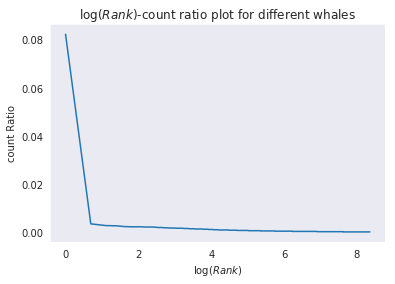

In [24]:
plt.plot(dfCount["logRanking"],dfCount["countRatio"])
plt.xlabel("$\log(Rank)$")
plt.ylabel("count Ratio")
plt.title("$\log(Rank)$-count ratio plot for different whales")

- Based on the above plot we see tnat most whales belong to one particular class and all the other classes have relatively same number of images
- We now get the top 10 labels to find the class with highest images.
- The dataset is highly imbalanced
Given from the above plot, most classes have just 1 image. This makes building a validation set extremely difficult. 

In [25]:
dfCount.iloc[0:10,:]

,Id,imgCount,countRatio,countBasedRanking,logRanking
0,new_whale,810,0.082234,0,0.000000
310,w_1287fbc,34,0.003452,1,0.693147
2580,w_98baff9,27,0.002741,2,1.098612
1951,w_7554f44,26,0.002640,3,1.386294
498,w_1eafe46,23,0.002335,4,1.609438
4197,w_fd1cb9d,22,0.002234,5,1.791759
2859,w_ab4cae2,22,0.002234,6,1.945910
1739,w_693c9ee,22,0.002234,7,2.079442
2573,w_987a36f,21,0.002132,8,2.197225
1118,w_43be268,21,0.002132,9,2.302585


Most of the images in the above dataset belong to the new whale class. A naive popularity based classifier evaluating on accuracy would fail drastically here. 
This is because- 
- We have more datain test image than training data, meaning we really need to optimize the model
- A classifier evaluating on accuracy could simply return the most popular class for most examples and still be popular. 

Here we need to focus more on the other classes that are present. I think data augmentation techniques can be helpful here.

#### Exploring images

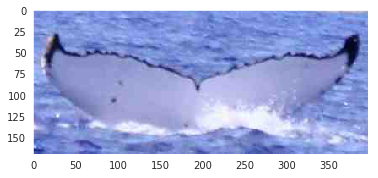

In [26]:
sample = "../input/train/train/001296d5.jpg"
sample = mpimg.imread(sample)
plt.imshow(sample)

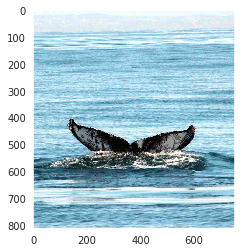

In [27]:
sample = "../input/train/train/020028b2.jpg"
sample = mpimg.imread(sample)
plt.imshow(sample)

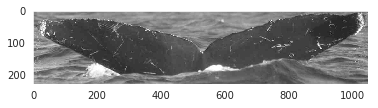

In [28]:
sample = "../input/train/train/2f3ec8a6.jpg"
sample = mpimg.imread(sample)
plt.imshow(sample)

Going through these images and going manually through the training data images given in the data, we can see that images vary in size and some have been edited. Some images also carry additonal details or are black and white.

This can be more  clear by looking at some random selection of images

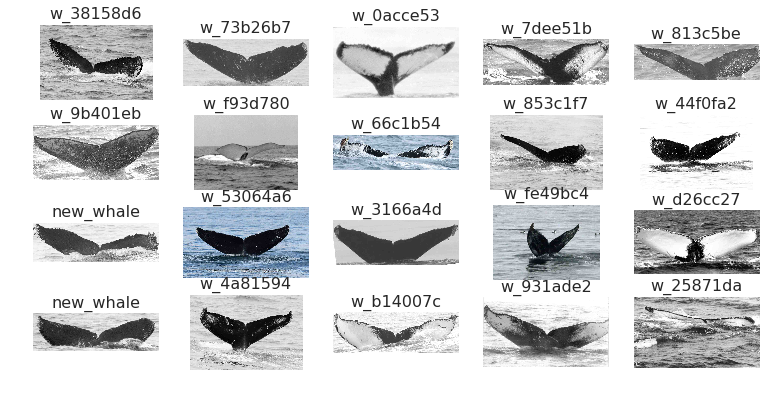

In [29]:
randomRows = df.sample(frac=1.)[:20]
rowVal = 5
imgs = [plt.imread(f'../input/train/train/{file}') for file in list(randomRows['Image'])]
imgLabel = list(randomRows['Id'])
figure = plt.figure(figsize=(13, 8))
cols = len(imgs) // rowVal + 1

for i in range(len(imgs)):
    subplot = figure.add_subplot(rowVal, cols, i + 1)
    subplot.axis('Off')
    if imgLabel:
        subplot.set_title(imgLabel[i], fontsize=16)
    plt.imshow(imgs[i], cmap='gray')

Adding on to the observation and the plot above, we either need a shape independent model or we need to compress the image to the smaller size. We also need a model indifferent to coloring scheme. The best way to proceed can be using a flexible feature extraction piepeline before modelling

#### Distribution of different RGB scales
We saw above that some images have RGB vaules, some black and white. We also have some edited images. Hence it will be beneficial to understand the distribution.

We need to check if the image is grayscale, or is RGB. 
I have taken the code as it is from - We https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli

We also have images that have been modified. However I am not sure we can detect that for all the images without examining each of the pixels of all the images. Also, I am not sure how to do that in python. Hence I have skipped it.

We apply the code to only to a sample, because of limited capacities of the kernel CPU

In [34]:
#function from https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli
def is_grey_scale(img_path):
    img = Image.open(f'../input/train/train/{img_path}').convert('RGB')
    w,h = img.size
    for i in range(w):
        for j in range(h):
            r,g,b = img.getpixel((i,j))
            if r != g != b: return False
    return True

In [35]:
is_grey = [is_grey_scale(i) for i in df['Image'].sample(frac=0.1)]
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(f"% of grey images: {grey_perc}")

% of grey images: 47.31


#### Exploring the dataset size scale
To downsize the images, we need to have some idea about distribution of image sizes

In [31]:
imgSizeData = collections.Counter([Image.open(f'../input/train/train/{filename}').size
                        for filename in df['Image']])
dfImgSize = pd.DataFrame(list(imgSizeData.most_common()),columns = ["imgSize","sizeCount"])
dfImgSize["sizeCountRatio"] = dfImgSize["sizeCount"] / np.sum(dfImgSize["sizeCount"])
dfImgSize["sizeRanking"] = range(dfImgSize.shape[0])
dfImgSize["logRanking"] = np.log(dfImgSize["sizeRanking"] + 1)

Text(0.5,1,'log(Size Based Ranking) - Size count Ratio')

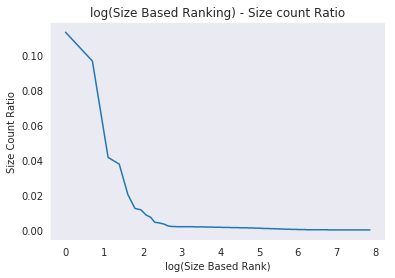

In [32]:
plt.plot(dfImgSize["logRanking"],dfImgSize["sizeCountRatio"])
plt.xlabel("log(Size Based Rank)")
plt.ylabel("Size Count Ratio")
plt.title("log(Size Based Ranking) - Size count Ratio")

As can be seen from the plot above, we have many different sizes between the training images. Hence, we need to do a lot of size based transformation.

In [33]:
dfImgSize.iloc[0:10,:]

,imgSize,sizeCount,sizeCountRatio,sizeRanking,logRanking
0,"(1050, 600)",1113,0.112995,0,0.000000
1,"(1050, 700)",951,0.096548,1,0.693147
2,"(1050, 450)",409,0.041523,2,1.098612
3,"(1050, 525)",371,0.037665,3,1.386294
4,"(700, 500)",200,0.020305,4,1.609438
5,"(1000, 667)",122,0.012386,5,1.791759
6,"(1050, 630)",114,0.011574,6,1.945910
7,"(1000, 652)",85,0.008629,7,2.079442
8,"(900, 600)",72,0.007310,8,2.197225
9,"(1050, 599)",44,0.004467,9,2.302585


From the above table, we can see that a lot of images are concentrated between sizes (1050, 600) and (1050, 700). We can assume that the test data will follow somewhat similar pattern in terms of data sizes. We use this table to select the best size for resizing. This will add some noise to the small images

#### Data Augmentation
Based on the above stats, we can see that it would help us to transform and augmenbt the data. This can be achieved by a lot of ways - 
1. Rotation
2. Random zooming a ceratin portion of the image
3. Random shearing of the image
4. Adding a shift to the image to add noise

We use keras library for this purpose. 

I try with three things - 
1. Using RGB images with a simple convolution network
2. Use data augmentation with CNNs
3. Use grayscale images with CNNS.

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
df["Image"] = df["Image"].map( lambda x : "../input/train/train/"+x)

In [6]:
X = np.zeros((df.shape[0], 100, 100, 3))
count = 0
for file in df['Image']:
    #load images into images of size 100x100x3
    img = image.load_img(file, target_size=(100, 100, 3))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    X[count] = x
    count += 1

In [7]:
lblEncoder = LabelEncoder()
Y = np.array(df['Id'])
Y_train = lblEncoder.fit_transform(Y)
Y_train = Y_train.reshape(len(Y), 1)
oneEncoder = OneHotEncoder(sparse=False,categories='auto')
Y_train = Y_train.reshape(len(Y_train), 1)
Y_train = oneEncoder.fit_transform(Y_train)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint

The following is a basic CNN model. I want to see if this model can grasp the details of the data.

In [35]:
def cnn_model(size, num_cnn_layers):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), name='max_pool'))
    
    model.add(Conv2D(64, (3, 3), name="conv1"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((3, 3), name='avg_pool1'))
    
    model.add(Conv2D(32, (3, 3), strides = (1,1), name="conv2"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((3, 3), name='avg_pool2'))

    model.add(Flatten())
    model.add(Dense(100, activation="relu", name='rl'))
    model.add(Dropout(0.5))
    model.add(Dense(4251, activation='softmax', name='sm'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return model

In [36]:
model = cnn_model((100,100,3), 3)

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 98, 98, 128)       3584      
_________________________________________________________________
activation_48 (Activation)   (None, 98, 98, 128)       0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 49, 49, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 47, 47, 64)        73792     
_________________________________________________________________
activation_49 (Activation)   (None, 47, 47, 64)        0         
_________________________________________________________________
avg_pool1 (MaxPooling2D)     (None, 15, 15, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        18464     
__________

In [38]:
pointStop = 20 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pointStop, verbose=1)
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model((100,100, 3), 3)
    model_checkpoint = ModelCheckpoint('whaleModel.h5', verbose=1, save_best_only=True)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping, model_checkpoint],  
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results


In [39]:
n_folds=3
epochs=100
batch_size=16

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, Y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 7978 samples, validate on 887 samples
Epoch 1/100
7978/7978 [==============================] - 7s 854us/step - loss: 8.2288 - acc: 0.0778 - val_loss: 8.1403 - val_acc: 0.0834

Epoch 00001: val_loss improved from inf to 8.14035, saving model to whaleModel.h5
Epoch 2/100
7978/7978 [==============================] - 6s 733us/step - loss: 7.8801 - acc: 0.0803 - val_loss: 8.1317 - val_acc: 0.0834

Epoch 00002: val_loss improved from 8.14035 to 8.13170, saving model to whaleModel.h5
Epoch 3/100
7978/7978 [==============================] - 6s 740us/step - loss: 7.7504 - acc: 0.0803 - val_loss: 8.2586 - val_acc: 0.0834

Epoch 00003: val_loss did not improve from 8.13170
Epoch 4/100
7978/7978 [==============================] - 6s 736us/step - loss: 7.7105 - acc: 0.0803 - val_loss: 8.3513 - val_acc: 0.0834

Epoch 00004: val_loss did not improve from 8.13170
Epoch 5/100
7978/7978 [==============================] - 6s 737us/step - loss: 7.6950 - acc: 0.0803 - val_loss


Epoch 00019: val_loss did not improve from 8.06109
Epoch 20/100
7978/7978 [==============================] - 6s 732us/step - loss: 6.5960 - acc: 0.0857 - val_loss: 9.7737 - val_acc: 0.0868

Epoch 00020: val_loss did not improve from 8.06109
Epoch 21/100
7978/7978 [==============================] - 6s 737us/step - loss: 6.5399 - acc: 0.0864 - val_loss: 9.9903 - val_acc: 0.0891

Epoch 00021: val_loss did not improve from 8.06109
Epoch 22/100
7978/7978 [==============================] - 6s 730us/step - loss: 6.4466 - acc: 0.0865 - val_loss: 10.1581 - val_acc: 0.0902

Epoch 00022: val_loss did not improve from 8.06109
Epoch 00022: early stopping
985/985 [==============================] - 0s 294us/step
Val Score:  [10.068786568811097, 0.08121827406629088]


Training on Fold:  3
Train on 7978 samples, validate on 887 samples
Epoch 1/100
7978/7978 [==============================] - 7s 873us/step - loss: 8.2473 - acc: 0.0801 - val_loss: 8.3614 - val_acc: 0.0722

Epoch 00001: val_loss improved

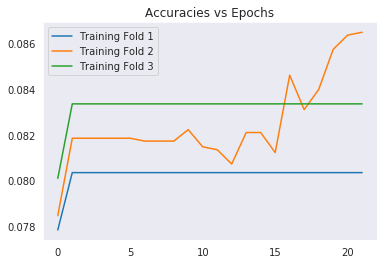

In [40]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.legend()
plt.show()

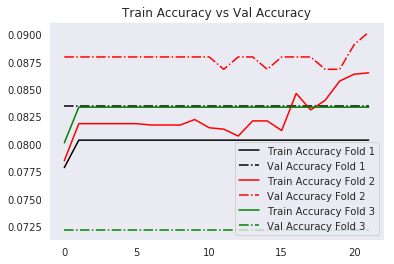

In [41]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()


Based on the above plot and some experiments, we  see that:
1. In the above plots, we see that neither simple CNNs nor data augmentation work. In reality a simple model with simple RGB images and no additional information can lead the model to train upto getting 92% accuracy. However, this cannot be translated to validation data. Addition of noise, by batch normalisation, and dropout drops the performance on both the training data and validation set. I believe that there are some subtle difference in the images that cannot be captured here. More adavnced CNN models with fine tuned parameters can be trained. However, I haven't added them here, due to the limit of processing.

In [9]:
def cnn_model(size, num_cnn_layers):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), name='max_pool'))
    
    model.add(Conv2D(64, (3, 3), name="conv1"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((3, 3), name='avg_pool1'))
    
    model.add(Conv2D(32, (3, 3), strides = (1,1), name="conv2"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((3, 3), name='avg_pool2'))

    model.add(Flatten())
    model.add(Dense(100, activation="relu", name='rl'))
    model.add(Dropout(0.5))
    model.add(Dense(4251, activation='softmax', name='sm'))
    model.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=['accuracy'])
    
    return model

In [10]:
model = cnn_model((100,100,3), 3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 98, 98, 128)       3584      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 128)       0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 49, 49, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 47, 47, 64)        73792     
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 64)        0         
_________________________________________________________________
avg_pool1 (MaxPooling2D)     (None, 15, 15, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        18464     
__________

In [11]:
#function from https://hub.packtpub.com/train-convolutional-neural-network-in-keras-improve-with-data-augmentation/
def create_datagen(X):
    data_generator = ImageDataGenerator(
        rotation_range=30,zoom_range=[0.7, 1.5],width_shift_range=0.1, 
        height_shift_range=0.3, shear_range=0.4,horizontal_flip=True, fill_mode="nearest")
    data_generator.fit(X, augment=True)
    return data_generator

In [12]:
cDataGen = create_datagen(X)

In [13]:
pointStop = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pointStop, verbose=1)
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model((100,100, 3), 3)
    model_checkpoint = ModelCheckpoint('whaleModel.h5', verbose=1, save_best_only=True)
    results =model.fit_generator(cDataGen.flow(t_x, t_y, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(t_x) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_x, val_y),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [14]:
n_folds=3
epochs=100
batch_size=16

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, Y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/100
554/554 [==============================] - 23s 41ms/step - loss: 8.1794 - acc: 0.0801 - val_loss: 8.0657 - val_acc: 0.0701

Epoch 00001: val_loss improved from inf to 8.06574, saving model to whaleModel.h5
Epoch 2/100
554/554 [==============================] - 20s 36ms/step - loss: 7.9488 - acc: 0.0834 - val_loss: 8.0003 - val_acc: 0.0701

Epoch 00002: val_loss improved from 8.06574 to 8.00026, saving model to whaleModel.h5
Epoch 3/100
554/554 [==============================] - 20s 37ms/step - loss: 7.8910 - acc: 0.0833 - val_loss: 7.9892 - val_acc: 0.0701

Epoch 00003: val_loss improved from 8.00026 to 7.98924, saving model to whaleModel.h5
Epoch 4/100
554/554 [==============================] - 21s 38ms/step - loss: 7.8701 - acc: 0.0838 - val_loss: 7.9787 - val_acc: 0.0701

Epoch 00004: val_loss improved from 7.98924 to 7.97865, saving model to whaleModel.h5
Epoch 5/100
554/554 [==============================] - 20s 36ms/step - loss: 7.8401 - acc: 0.08

554/554 [==============================] - 20s 37ms/step - loss: 7.8210 - acc: 0.0836 - val_loss: 7.9567 - val_acc: 0.0680

Epoch 00007: val_loss did not improve from 7.95135
Epoch 8/100
554/554 [==============================] - 20s 36ms/step - loss: 7.8108 - acc: 0.0843 - val_loss: 7.9587 - val_acc: 0.0680

Epoch 00008: val_loss did not improve from 7.95135
Epoch 9/100
554/554 [==============================] - 20s 37ms/step - loss: 7.8214 - acc: 0.0825 - val_loss: 7.9564 - val_acc: 0.0680

Epoch 00009: val_loss did not improve from 7.95135
Epoch 10/100
554/554 [==============================] - 22s 40ms/step - loss: 7.7954 - acc: 0.0862 - val_loss: 7.9536 - val_acc: 0.0680

Epoch 00010: val_loss did not improve from 7.95135
Epoch 11/100
554/554 [==============================] - 21s 38ms/step - loss: 7.8055 - acc: 0.0835 - val_loss: 7.9548 - val_acc: 0.0680

Epoch 00011: val_loss did not improve from 7.95135
Epoch 12/100
554/554 [==============================] - 20s 36ms/step - los

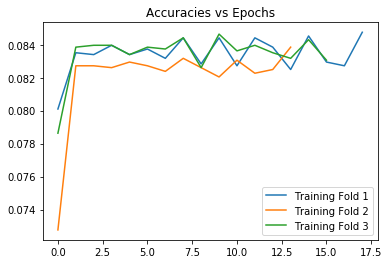

In [15]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.legend()
plt.show()

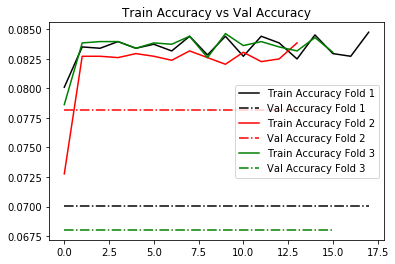

In [16]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

None of the above models work very well. We are using early stopping here. However, if we do not use early stopping, we see that the training accuracy reaches a high value range from (70%-92%) depending on model configuration. However, we do not find any increase in the validation accuracy beyond max of 16% (depending on the the data configuration). Moreover, we see that the validation loss keeps on increasing.

One thing I did not do was use grayscale images. It can be worth checking if grayscaling the images. Hence we try to repeat the above experiments with a grayscale image. I believe that this might help us because grayscale images help us in distinguishing certain features, which might be esily seperatable due to the noise in the colored signal.

Below we check if grayscale images work well. This is because, it is easier to train large network with grayscale images. Grayscale images at times capture subtleties that are lost in signal noise of RGB images. However, these do not work at all. I think adding weights for classes can produce better results. 

In [8]:
SIZE = 100
#image are imported with a resizing and a black and white conversion
def ImportImage( filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]
X = np.array([ImportImage( img) for img in df.Image])


In [9]:
lblEncoder = LabelEncoder()
Y = np.array(df['Id'])
Y_train = lblEncoder.fit_transform(Y)
Y_train = Y_train.reshape(len(Y), 1)
oneEncoder = OneHotEncoder(sparse=False,categories='auto')
Y_train = Y_train.reshape(len(Y_train), 1)
Y_train = oneEncoder.fit_transform(Y_train)

In [10]:
X = X.reshape( (-1,SIZE,SIZE,1))
input_shape = X[0].shape
X = X.astype("float32")

In [26]:
def cnn_model(size):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides = (1, 1), name = 'conv0', input_shape =size))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), name='max_pool'))
    
    model.add(Conv2D(64, (3, 3), name="conv1"))
    model.add(Activation('sigmoid'))
    model.add(MaxPooling2D((3, 3), name='avg_pool1'))
    
    model.add(Conv2D(32, (3, 3), strides = (1,1), name="conv2"))
    model.add(Activation('sigmoid'))
    model.add(MaxPooling2D((3, 3), name='avg_pool2'))

    model.add(Flatten())
    model.add(Dense(100, activation="relu", name='rl'))
    model.add(Dropout(0.5))
    model.add(Dense(4251, activation='softmax', name='sm'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return model

In [27]:
model = cnn_model(input_shape)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 98, 98, 128)       1280      
_________________________________________________________________
activation_36 (Activation)   (None, 98, 98, 128)       0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 49, 49, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 47, 47, 64)        73792     
_________________________________________________________________
activation_37 (Activation)   (None, 47, 47, 64)        0         
_________________________________________________________________
avg_pool1 (MaxPooling2D)     (None, 15, 15, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        18464     
__________

In [29]:
pointStop =10 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pointStop, verbose=1)
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model((100,100, 1))
    model_checkpoint = ModelCheckpoint('test.h5', verbose=1, save_best_only=True)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping,model_checkpoint],  
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results



In [30]:
n_folds=3
epochs=100
batch_size=16

#save the model history in a list after fitting so that we can plot later
model_history = [] 
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, Y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 7978 samples, validate on 887 samples
Epoch 1/100
7978/7978 [==============================] - 6s 758us/step - loss: 8.1254 - acc: 0.0812 - val_loss: 8.1208 - val_acc: 0.0722

Epoch 00001: val_loss improved from inf to 8.12076, saving model to test.h5
Epoch 2/100
7978/7978 [==============================] - 5s 673us/step - loss: 7.8644 - acc: 0.0835 - val_loss: 8.2732 - val_acc: 0.0722

Epoch 00002: val_loss did not improve from 8.12076
Epoch 3/100
7978/7978 [==============================] - 5s 637us/step - loss: 7.7965 - acc: 0.0835 - val_loss: 8.4139 - val_acc: 0.0722

Epoch 00003: val_loss did not improve from 8.12076
Epoch 4/100
7978/7978 [==============================] - 5s 637us/step - loss: 7.7712 - acc: 0.0835 - val_loss: 8.4921 - val_acc: 0.0722

Epoch 00004: val_loss did not improve from 8.12076
Epoch 5/100
7978/7978 [==============================] - 5s 636us/step - loss: 7.7649 - acc: 0.0835 - val_loss: 8.6165 - val_acc: 0.0722

Epoch 00005: 

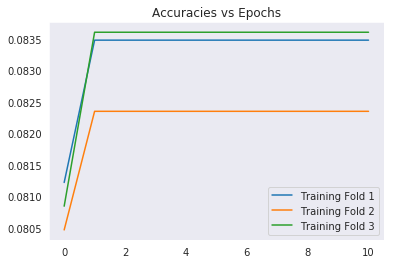

In [31]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.legend()
plt.show()

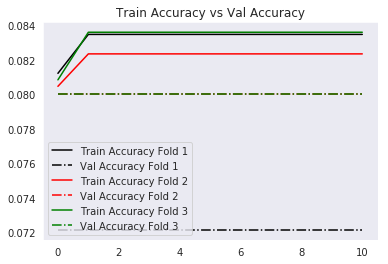

In [32]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

As we see from above results, none of the methods work well. The models are failing to generalize well. It might be helpful to use advanced models such as resNet and do more intricate feature extractions. Bounding boxes around whale fins and then application of transformations for data augmentation might be helpful.However, for the purpose of seeing how it performs, in the final test, I am training a more deper network. My understanding is - once the convolution networks provides feature maps, we might be able to use a really deep fully connected layer to learn from these features and then use them for prediction. In the model below, I use all of the training data for training and then generate validation data using ImageDataGenertor. I perform this on grayscale images because they allow for less parameters to be trained for lesser number of operations

In [21]:
def cnn_model(size):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides = (1, 1), name = 'conv0', input_shape =size))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), name='max_pool'))
    
    model.add(Conv2D(64, (3, 3), name="conv1"))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D((2, 2), name='avg_pool1'))
    
    model.add(Conv2D(32, (3, 3), strides = (1,1), name="conv2"))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D((2, 2), name='avg_pool2'))
    
    model.add(Conv2D(32, (3, 3), strides = (1,1), name="conv3"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), name='avg_pool3'))

    model.add(Flatten())
    model.add(Dense(100, activation="relu", name='rl'))
    model.add(Dropout(0.5))
    model.add(Dense(500, activation="relu", name='r2'))
    model.add(Dropout(0.5))
    model.add(Dense(1500, activation="relu", name='r3'))
    model.add(Dropout(0.5))
    model.add(Dense(3000, activation="relu", name='r4'))
    model.add(Dropout(0.5))
    model.add(Dense(4251, activation='softmax', name='sm'))
    model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])
    
    return model

In [22]:
model = cnn_model(input_shape)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 98, 98, 128)       1280      
_________________________________________________________________
activation_20 (Activation)   (None, 98, 98, 128)       0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 49, 49, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 47, 47, 64)        73792     
_________________________________________________________________
activation_21 (Activation)   (None, 47, 47, 64)        0         
_________________________________________________________________
avg_pool1 (MaxPooling2D)     (None, 23, 23, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 21, 21, 32)        18464     
__________

In [24]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model((100,100, 1))
    results =model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE,  
              verbose=1, validation_split=0.1) 
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [25]:
n_folds=3
epochs=100
batch_size=16

#save the model history in a list after fitting so that we can plot later
model_history = [] 
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, Y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 7978 samples, validate on 887 samples
Epoch 1/100
7978/7978 [==============================] - 9s 1ms/step - loss: 8.0489 - acc: 0.0797 - val_loss: 8.1860 - val_acc: 0.0699
Epoch 2/100
7978/7978 [==============================] - 6s 789us/step - loss: 7.9286 - acc: 0.0832 - val_loss: 8.1631 - val_acc: 0.0699
Epoch 3/100
7978/7978 [==============================] - 6s 784us/step - loss: 7.8586 - acc: 0.0832 - val_loss: 8.1539 - val_acc: 0.0699
Epoch 4/100
7978/7978 [==============================] - 6s 799us/step - loss: 7.8191 - acc: 0.0832 - val_loss: 8.1418 - val_acc: 0.0699
Epoch 5/100
7978/7978 [==============================] - 6s 810us/step - loss: 7.7877 - acc: 0.0832 - val_loss: 8.1445 - val_acc: 0.0699
Epoch 6/100
7978/7978 [==============================] - 7s 820us/step - loss: 7.7750 - acc: 0.0832 - val_loss: 8.1711 - val_acc: 0.0699
Epoch 7/100
7978/7978 [==============================] - 6s 813us/step - loss: 7.7561 - acc: 0.0832 - val_loss: 

Epoch 60/100
7978/7978 [==============================] - 6s 783us/step - loss: 7.6306 - acc: 0.0832 - val_loss: 8.2363 - val_acc: 0.0699
Epoch 61/100
7978/7978 [==============================] - 6s 782us/step - loss: 7.6303 - acc: 0.0832 - val_loss: 8.2471 - val_acc: 0.0699
Epoch 62/100
7978/7978 [==============================] - 6s 781us/step - loss: 7.6270 - acc: 0.0832 - val_loss: 8.2387 - val_acc: 0.0699
Epoch 63/100
7978/7978 [==============================] - 6s 781us/step - loss: 7.6268 - acc: 0.0832 - val_loss: 8.2408 - val_acc: 0.0699
Epoch 64/100
7978/7978 [==============================] - 6s 783us/step - loss: 7.6256 - acc: 0.0832 - val_loss: 8.2356 - val_acc: 0.0699
Epoch 65/100
7978/7978 [==============================] - 6s 784us/step - loss: 7.6289 - acc: 0.0832 - val_loss: 8.2495 - val_acc: 0.0699
Epoch 66/100
7978/7978 [==============================] - 6s 783us/step - loss: 7.6281 - acc: 0.0832 - val_loss: 8.2781 - val_acc: 0.0699
Epoch 67/100
7978/7978 [==========

7978/7978 [==============================] - 6s 785us/step - loss: 7.7038 - acc: 0.0820 - val_loss: 8.1298 - val_acc: 0.0800
Epoch 18/100
7978/7978 [==============================] - 6s 786us/step - loss: 7.6960 - acc: 0.0820 - val_loss: 8.0986 - val_acc: 0.0800
Epoch 19/100
7978/7978 [==============================] - 6s 811us/step - loss: 7.6964 - acc: 0.0820 - val_loss: 8.1203 - val_acc: 0.0800
Epoch 20/100
7978/7978 [==============================] - 6s 800us/step - loss: 7.6925 - acc: 0.0820 - val_loss: 8.1096 - val_acc: 0.0800
Epoch 21/100
7978/7978 [==============================] - 6s 788us/step - loss: 7.6951 - acc: 0.0820 - val_loss: 8.0966 - val_acc: 0.0800
Epoch 22/100
7978/7978 [==============================] - 6s 804us/step - loss: 7.6875 - acc: 0.0820 - val_loss: 8.1165 - val_acc: 0.0800
Epoch 23/100
7978/7978 [==============================] - 6s 796us/step - loss: 7.6841 - acc: 0.0820 - val_loss: 8.1187 - val_acc: 0.0800
Epoch 24/100
7978/7978 [=======================

7978/7978 [==============================] - 6s 782us/step - loss: 7.6288 - acc: 0.0820 - val_loss: 8.1191 - val_acc: 0.0800
Epoch 77/100
7978/7978 [==============================] - 6s 781us/step - loss: 7.6215 - acc: 0.0820 - val_loss: 8.1387 - val_acc: 0.0800
Epoch 78/100
7978/7978 [==============================] - 6s 782us/step - loss: 7.6221 - acc: 0.0820 - val_loss: 8.1217 - val_acc: 0.0800
Epoch 79/100
7978/7978 [==============================] - 6s 784us/step - loss: 7.6224 - acc: 0.0820 - val_loss: 8.1382 - val_acc: 0.0800
Epoch 80/100
7978/7978 [==============================] - 6s 782us/step - loss: 7.6231 - acc: 0.0820 - val_loss: 8.1373 - val_acc: 0.0800
Epoch 81/100
7978/7978 [==============================] - 6s 784us/step - loss: 7.6180 - acc: 0.0820 - val_loss: 8.1217 - val_acc: 0.0800
Epoch 82/100
7978/7978 [==============================] - 6s 782us/step - loss: 7.6153 - acc: 0.0820 - val_loss: 8.1383 - val_acc: 0.0800
Epoch 83/100
7978/7978 [=======================

7978/7978 [==============================] - 6s 793us/step - loss: 7.6591 - acc: 0.0839 - val_loss: 8.1112 - val_acc: 0.0688
Epoch 34/100
7978/7978 [==============================] - 6s 812us/step - loss: 7.6649 - acc: 0.0839 - val_loss: 8.1122 - val_acc: 0.0688
Epoch 35/100
7978/7978 [==============================] - 6s 790us/step - loss: 7.6619 - acc: 0.0839 - val_loss: 8.1174 - val_acc: 0.0688
Epoch 36/100
7978/7978 [==============================] - 6s 786us/step - loss: 7.6655 - acc: 0.0839 - val_loss: 8.1128 - val_acc: 0.0688
Epoch 37/100
7978/7978 [==============================] - 6s 783us/step - loss: 7.6569 - acc: 0.0839 - val_loss: 8.0985 - val_acc: 0.0688
Epoch 38/100
7978/7978 [==============================] - 6s 784us/step - loss: 7.6603 - acc: 0.0839 - val_loss: 8.1043 - val_acc: 0.0688
Epoch 39/100
7978/7978 [==============================] - 6s 783us/step - loss: 7.6597 - acc: 0.0839 - val_loss: 8.1101 - val_acc: 0.0688
Epoch 40/100
7978/7978 [=======================

7978/7978 [==============================] - 6s 782us/step - loss: 7.6278 - acc: 0.0839 - val_loss: 8.2441 - val_acc: 0.0688
Epoch 93/100
7978/7978 [==============================] - 6s 785us/step - loss: 7.6284 - acc: 0.0839 - val_loss: 8.2335 - val_acc: 0.0688
Epoch 94/100
7978/7978 [==============================] - 6s 782us/step - loss: 7.6277 - acc: 0.0839 - val_loss: 8.2476 - val_acc: 0.0688
Epoch 95/100
7978/7978 [==============================] - 6s 781us/step - loss: 7.6266 - acc: 0.0839 - val_loss: 8.2457 - val_acc: 0.0688
Epoch 96/100
7978/7978 [==============================] - 6s 780us/step - loss: 7.6257 - acc: 0.0839 - val_loss: 8.2543 - val_acc: 0.0688
Epoch 97/100
7978/7978 [==============================] - 6s 794us/step - loss: 7.6248 - acc: 0.0839 - val_loss: 8.2482 - val_acc: 0.0688
Epoch 98/100
7978/7978 [==============================] - 6s 806us/step - loss: 7.6233 - acc: 0.0839 - val_loss: 8.2478 - val_acc: 0.0688
Epoch 99/100
7978/7978 [=======================

I think making a more complex model will help in learning the general features in the image and can help. We can also add weight based updates for class labels.The models are not learning. Especially the grayscale model. I do not think this is the best model. We can fine tune the model more. But more advancedmodels will be able to learn non-linear and discrete relations between the images. The difference are very subtle hence a more advanced model such as Resnet or Single shot network might work better.
